<a href="https://colab.research.google.com/github/rayan-roy/Team-Snowflakes/blob/main/Cyclica_challenge_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Business Context**

Cyclica has mapped all verifiable drug binding sites onto AlphaFold2 protein structures. They have then labeled each protein residue as 'drug binding' or 'non-drug binding'. Moreover, they have generated data-rich features for each residue in the dataset, derived exclusively from the AF2-predicted protein structure using standard structural biology tools.


**Problem Statement**

Our goal is to build a classification model to predict the drug binding sites on AlphaFold2-predicted proteins. We do this by:

1.  Classifying residue as either 'drug binding site' or 'non-binding site'
2.  Listing out the most important features/columns for drug binding



## Exploratory Data Analysis

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Importing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
import lightgbm
from lightgbm import LGBMClassifier
from statistics import mean

In [37]:
df_train = pd.read_csv("/content/drive/MyDrive/af2_dataset_training_labeled.csv.gz", index_col=0)
df_train.head(5)

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670,-26.858999,GEMI5_HUMAN,4,False


All the variable containing *feat_** are boolean in nature in order to represent the different amino acid sequence

In [38]:
df_train.isna().sum() 

annotation_sequence        0
feat_A                     0
feat_C                     0
feat_D                     0
feat_E                     0
feat_F                     0
feat_G                     0
feat_H                     0
feat_I                     0
feat_K                     0
feat_L                     0
feat_M                     0
feat_N                     0
feat_P                     0
feat_Q                     0
feat_R                     0
feat_S                     0
feat_T                     0
feat_V                     0
feat_W                     0
feat_Y                     0
annotation_atomrec     12689
feat_PHI                   0
feat_PSI                   0
feat_TAU                   0
feat_THETA                 0
feat_BBSASA                0
feat_SCSASA                0
feat_pLDDT                 0
feat_DSSP_H                0
feat_DSSP_B                0
feat_DSSP_E                0
feat_DSSP_G                0
feat_DSSP_I                0
feat_DSSP_T   

Only annotation atomrec has missing values. We also found out that *annotation_atomrec* variable and *annotation_sequence* are identical

We will be removing all the optional columns that was provided to us except the x,y,z coordinates. We fitted model using these columns but got very poor scores

In [39]:
df_train = df_train.drop(columns =['annotation_atomrec','annotation_sequence','entry', 'entry_index'], axis = 1)

In [40]:
df_train.dtypes

feat_A             bool
feat_C             bool
feat_D             bool
feat_E             bool
feat_F             bool
feat_G             bool
feat_H             bool
feat_I             bool
feat_K             bool
feat_L             bool
feat_M             bool
feat_N             bool
feat_P             bool
feat_Q             bool
feat_R             bool
feat_S             bool
feat_T             bool
feat_V             bool
feat_W             bool
feat_Y             bool
feat_PHI        float64
feat_PSI        float64
feat_TAU        float64
feat_THETA      float64
feat_BBSASA     float64
feat_SCSASA     float64
feat_pLDDT      float64
feat_DSSP_H        bool
feat_DSSP_B        bool
feat_DSSP_E        bool
feat_DSSP_G        bool
feat_DSSP_I        bool
feat_DSSP_T        bool
feat_DSSP_S        bool
feat_DSSP_6       int64
feat_DSSP_7     float64
feat_DSSP_8       int64
feat_DSSP_9     float64
feat_DSSP_10      int64
feat_DSSP_11    float64
feat_DSSP_12      int64
feat_DSSP_13    

As we can see there are lot of Boolean values. We will convert them into numeric values.

In [41]:
df_train = df_train.applymap(lambda x: 1 if x == True else x)
df_train = df_train.applymap(lambda x: 0 if x == False else x)

We will also be exploring the SCSASA which describes the solvent accessible surface area. Ideally these values should not be negative.

In [42]:
len(df_train[df_train.feat_SCSASA < 0])

3386

As we can there are several negative SCSASA values. We will make all of them 0 if they are negative.

In [43]:
df_train[df_train.feat_SCSASA < 0] = 0

Lets explore the dependent variable using barplot

<AxesSubplot:xlabel='y_Ligand', ylabel='count'>

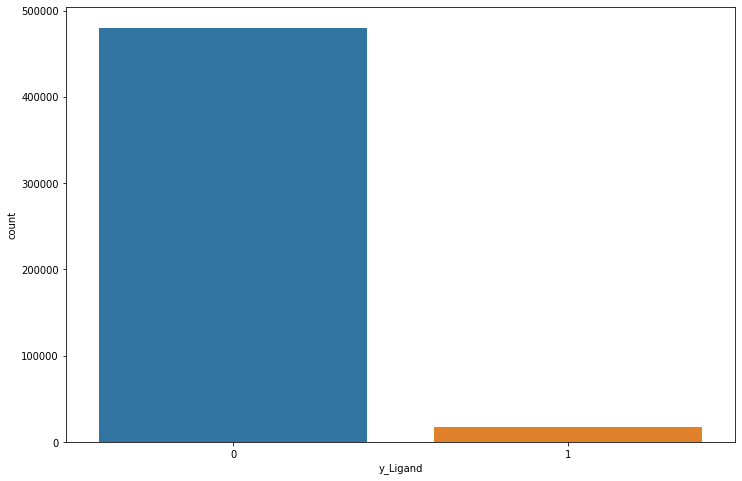

In [44]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.countplot(df_train.y_Ligand)

In [45]:
df_train.y_Ligand.value_counts()/df_train.shape[0]

0    0.965643
1    0.034357
Name: y_Ligand, dtype: float64

We see that 96% is false and 3.4% is True (i.e binding). The dataset is highly imbalanced.

## Model Building

Maybe we could add that first, you have to split into training and test set using stratify. Then second, to correct imbalance you eventually need to run oversampling or undersampling on the training set. Many Sklearn classifier has a parameter called class-weight which you can set to balanced. Finally you could also take a more appropriate metric than accuracy for imbalanced dataset. Try, F1 or area under ROC

 We will be using stratifying in test train split to maintain the balance of dataset.

In [46]:
X = df_train.drop(["y_Ligand"], axis=1)
Y = df_train["y_Ligand"].astype('int') # converted to integer
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify = Y)

Lets try **Random Forest Classifier Model**

In [47]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced')
rf.fit(X_train,y_train)
y_test_predrf = rf.predict(X_test)

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predrf, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
print('Recall of RF on test set: {:.2f}'.format(recall_score(y_test, y_test_predrf, average='binary'))) 
print('Precision of RF on test set: {:.2f}'.format(precision_score(y_test, y_test_predrf))) 
print('F1 score of RF on test set: {:.2f}'.format(f1_score(y_test, y_test_predrf, average='weighted'))) # to account for disbalance
precision, recall, _ = precision_recall_curve(y_test, y_test_predrf)
auc_pr = auc(recall, precision)

precision, recall, _ = metrics.precision_recall_curve(y_test, y_test_predrf)
auc_pr = metrics.auc(recall, precision)

print(f"ROC-AUC of RF on test set: {auc_roc}")
print(f"PR-AUC of RF on test set: {auc_pr}")

Recall of RF on test set: 0.12
Precision of RF on test set: 0.89
F1 score of RF on test set: 0.96
ROC-AUC of RF on test set: 0.5613091486007932
PR-AUC of RF on test set: 0.5228867759882059


Lets try **BalancedRandom Forest Classifier** which can automatically handle imbalanced dataset

In [49]:
# BalancedRandomForestClassifier
BRFC = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')
BRFC.fit(X_train,y_train)
y_test_predbrf = BRFC.predict(X_test)

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predbrf, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_test_predbrf)
auc_pr = auc(recall, precision)

print("Recall of BRF on test set:",metrics.recall_score(y_test, y_test_predbrf,average='binary')) 
print('Precision of BRF on test set: {:.2f}'.format(precision_score(y_test, y_test_predbrf))) 
print('F1 score of BRF on test set: {:.2f}'.format(f1_score(y_test, y_test_predbrf, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of BRF on test set: {auc_roc}")
print(f"PR-AUC of BRF on test set: {auc_pr}")

Recall of BRF on test set: 0.7455113192818111
Precision of BRF on test set: 0.11
F1 score of BRF on test set: 0.85
ROC-AUC of BRF on test set: 0.7641294393751202
PR-AUC of BRF on test set: 0.43152755350104327


Lets try **XgBoost classifier model**

In [51]:
# XgBoost
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
y_test_predxg = xgb.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predxg, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_test_predxg)
auc_pr = auc(recall, precision)

print("Recall of XGB on test set:",metrics.recall_score(y_test, y_test_predxg,average='binary')) 
print('Precision of XGB on test set: {:.2f}'.format(precision_score(y_test, y_test_predxg))) 
print('F1 score of XGB on test set: {:.2f}'.format(f1_score(y_test, y_test_predxg, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of XGB on test set: {auc_roc}")
print(f"PR-AUC of XGB on test set: {auc_pr}")

Recall of XGB on test set: 0.00234192037470726
Precision of XGB on test set: 0.92
F1 score of XGB on test set: 0.95
ROC-AUC of XGB on test set: 0.5011674885919473
PR-AUC of XGB on test set: 0.4798465320174679


We will also try **LightGBM classifier** and see if there are any improvements.

In [52]:
lgbm = LGBMClassifier(objective='binary')
lgbm.fit(X_train,y_train)
y_test_predlgbm = lgbm.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_test_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(y_test, y_test_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_test, y_test_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_test, y_test_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

Recall of LightGBM on test set: 0.10480093676814989
Precision of LightGBM on test set: 0.69
F1 score of LightGBM on test set: 0.96
ROC-AUC of LightGBM on test set: 0.5515811718681681
PR-AUC of LightGBM on test set: 0.41512560031972234


Look at the above models, it seems like BalancedRandomForest performed the best. We will further test it on a small resampled dataset and then cross validate it to ensure its consistent.

#### Testing on a smaller sample

In [53]:
df_true = df_train[df_train["y_Ligand"] == 1]
df_false = df_train[df_train["y_Ligand"] == 0]
df_fsamp = df_false.sample(n=20000, random_state=37)
df_balanced = pd.concat([df_true, df_fsamp])
df_bal_X = df_balanced.drop(["y_Ligand"], axis=1)
df_bal_Y = df_balanced["y_Ligand"]

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(df_bal_X, df_bal_Y, test_size=0.3, random_state=42, stratify = df_bal_Y)
BRFC_sam = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')
BRFC_sam.fit(X_train_sam,y_train_sam)
y_test_predbrf_sam = BRFC_sam.predict(X_test_sam)

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_sam, y_test_predbrf_sam, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test_sam, y_test_predbrf_sam)
auc_pr = auc(recall, precision)

print("Recall of RBF_sample on test set:",metrics.recall_score(y_test_sam, y_test_predbrf_sam,average='binary')) 
print('Precision of RBF_sample on test set: {:.2f}'.format(precision_score(y_test_sam, y_test_predbrf_sam))) 
print('F1 score of RBF_sample on test set: {:.2f}'.format(f1_score(y_test_sam, y_test_predbrf_sam, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of RBF_sample on test set: {auc_roc}")
print(f"PR-AUC of RBF_sample on test set: {auc_pr}")

Recall of RBF_sample on test set: 0.7923902439024391
Precision of RBF_sample on test set: 0.73
F1 score of RBF_sample on test set: 0.77
ROC-AUC of RBF_sample on test set: 0.7733617886178861
PR-AUC of RBF_sample on test set: 0.8108626818103387


The RBF model performed quite well on the sample set

### Cross validation

We will be using RepeatedStratifiedKFold in order to preserve the classes in imbalanced dataset

In [55]:
# Cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision', 'roc_auc', 'balanced_accuracy')
#Evaluate BRFC model
scores = cross_validate(BRFC, X, Y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1 for RBF: %.3f' % mean(scores['test_f1']))
print('Mean recall for RBF: %.3f' % mean(scores['test_recall']))
print('Mean precision for RBF: %.3f' % mean(scores['test_precision']))
print('Mean ROC-AUC for RBF: %.3f' % mean(scores['test_roc_auc']))
print('Mean balanced_accuracy for RBF: %.3f' % mean(scores['test_balanced_accuracy']))

Mean f1 for RBF: 0.194
Mean recall for RBF: 0.759
Mean precision for RBF: 0.111
Mean ROC-AUC for RBF: 0.864
Mean balanced_accuracy for RBF: 0.772


In [56]:
BRFC_sam.feature_importances_

array([0.00322116, 0.00182953, 0.00323203, 0.00369012, 0.00376174,
       0.00308269, 0.00191254, 0.00301592, 0.00339222, 0.00465448,
       0.00201718, 0.00262879, 0.00190766, 0.00269327, 0.00322368,
       0.00333703, 0.00281307, 0.00417923, 0.00190206, 0.00343933,
       0.04462605, 0.04569481, 0.04371291, 0.04898699, 0.05805363,
       0.07543161, 0.114923  , 0.00724703, 0.00099134, 0.00454538,
       0.00216309, 0.00066865, 0.00401793, 0.00378035, 0.0341973 ,
       0.04317267, 0.02827498, 0.03417951, 0.02989584, 0.02443302,
       0.03324643, 0.02497489, 0.07261676, 0.07846276, 0.08176937])

<AxesSubplot:>

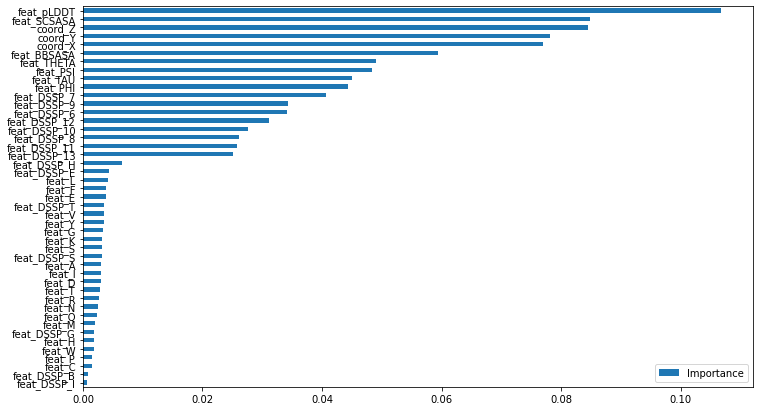

In [57]:
fi = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance'])
fi = fi.sort_values('Importance')
fi.plot.barh(figsize=(12,7))

In [76]:
importances = BRFC.feature_importances_
indices = np.argsort(importances)[-6:]
print(indices)

[25 23 44 43 42 26]


In [75]:
X.iloc[:, [24,25,42,43,44,26]]

,feat_BBSASA,feat_SCSASA,coord_X,coord_Y,coord_Z,feat_pLDDT
0,80.020602,137.023818,-26.499001,-4.742000,-35.189999,38.49
1,69.542382,0.000000,-25.158001,-1.342000,-34.104000,46.08
2,23.387401,88.587659,-21.926001,-1.641000,-32.175999,65.42
3,4.908812,44.521273,-22.073999,0.654000,-29.171000,85.17
4,9.742674,52.613700,-19.783001,2.670000,-26.858999,93.24
...,...,...,...,...,...,...
755,7.313673,48.994428,-19.742001,20.796000,-12.319000,95.81
756,20.300374,46.103273,-16.299000,19.153999,-12.640000,96.62
757,2.763823,0.000000,-13.404000,19.502001,-10.121000,93.61
758,15.092203,0.000000,-10.986000,20.320000,-13.016000,93.17


Compare ROC-AUC curve for test and train:

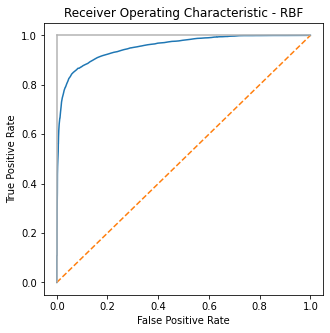

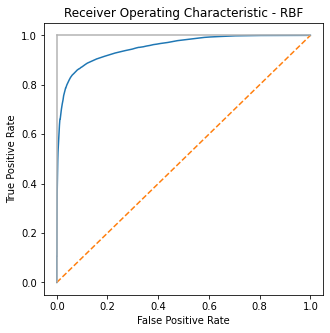

In [93]:
import matplotlib.pyplot as plt

y_score2 = BRFC.predict_proba(X_test_sam)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_sam, y_score2, pos_label=1)
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - RBF')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_score3 = BRFC.predict_proba(X_train_sam)[:,1]
fpr1, tpr1, thresholds = roc_curve(y_train_sam, y_score3, pos_label=1)
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - RBF')
plt.plot(fpr1, tpr1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see that ROC AUC for both train and test are almost quite close to each other. This is to check whether there is any overfitting occuring

**Based on a previous analysis of using Logistic regression (See earlier notebook), we found that 'feat_C', 'feat_D', 'feat_I', 'feat_K', 'feat_T', 'feat_V', 'feat_DSSP_12', 'feat_THETA' weren't significantly contributing. As a result, we will be removing them**

In [100]:
df_f = df_train.drop(['feat_C', 'feat_D', 'feat_I', 'feat_K', 'feat_T', 'feat_V', 'feat_DSSP_12', 'feat_THETA'], axis=1)

In [103]:
X_1 = df_f.drop(["y_Ligand"], axis=1)
Y_1 = df_f["y_Ligand"].astype('int') # converted to integer
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.3, random_state=42, stratify = Y_1)

In [104]:
BRFC_1 = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')
BRFC_1.fit(X_train_1,y_train_1)
y_test_predbrf_1 = BRFC_1.predict(X_test_1)
fpr, tpr, thresholds = metrics.roc_curve(y_test_1, y_test_predbrf_1, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test_1, y_test_predbrf_1)
auc_pr = auc(recall, precision)

print("Recall of RBF_sample on test set:",metrics.recall_score(y_test_1, y_test_predbrf_1,average='binary')) 
print('Precision of RBF_sample on test set: {:.2f}'.format(precision_score(y_test_1, y_test_predbrf_1))) 
print('F1 score of RBF_sample on test set: {:.2f}'.format(f1_score(y_test_1, y_test_predbrf_1, average='weighted'))) # to account for disbalance
print(f"ROC-AUC of RBF_sample on test set: {auc_roc}")
print(f"PR-AUC of RBF_sample on test set: {auc_pr}")

Recall of RBF_sample on test set: 0.7402419984387197
Precision of RBF_sample on test set: 0.11
F1 score of RBF_sample on test set: 0.85
ROC-AUC of RBF_sample on test set: 0.7639596116921079
PR-AUC of RBF_sample on test set: 0.42975706949682574


In [113]:
# Cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision', 'roc_auc', 'balanced_accuracy')
#Evaluate BRFC model
scores_1 = cross_validate(BRFC_1, X_1, Y_1, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1 for RBF: %.3f' % mean(scores_1['test_f1']))
print('Mean recall for RBF: %.3f' % mean(scores_1['test_recall']))
print('Mean precision for RBF: %.3f' % mean(scores_1['test_precision']))
print('Mean ROC-AUC for RBF: %.3f' % mean(scores_1['test_roc_auc']))
print('Mean balanced_accuracy for RBF: %.3f' % mean(scores_1['test_balanced_accuracy']))

Mean f1 for RBF: 0.195
Mean recall for RBF: 0.753
Mean precision for RBF: 0.112
Mean ROC-AUC for RBF: 0.860
Mean balanced_accuracy for RBF: 0.771


As we can see, after dropping variables we are stil getting similar results for our Balanced Random Forest Model. **Hence this is our final model**


In [112]:
importances = BRFC_1.feature_importances_
indices = np.argsort(importances)[-2:]
print(indices)
X_1.iloc[:, [17,18 ,36, 35, 34, 19]]

[34 19]


,feat_BBSASA,feat_SCSASA,coord_Z,coord_Y,coord_X,feat_pLDDT
0,80.020602,137.023818,-35.189999,-4.742000,-26.499001,38.49
1,69.542382,0.000000,-34.104000,-1.342000,-25.158001,46.08
2,23.387401,88.587659,-32.175999,-1.641000,-21.926001,65.42
3,4.908812,44.521273,-29.171000,0.654000,-22.073999,85.17
4,9.742674,52.613700,-26.858999,2.670000,-19.783001,93.24
...,...,...,...,...,...,...
755,7.313673,48.994428,-12.319000,20.796000,-19.742001,95.81
756,20.300374,46.103273,-12.640000,19.153999,-16.299000,96.62
757,2.763823,0.000000,-10.121000,19.502001,-13.404000,93.61
758,15.092203,0.000000,-13.016000,20.320000,-10.986000,93.17


Hence the most important features are **feat_plDDT, coord_X, coord_Y, coord_Z, feat_SCSASA ad feat_BBSASA**

## Submission Instructions

- Run inference on the test set and save the inference results as a csv file, the file should look like this
```
id,Predicted
0,True
1,False
2,True
3,False
....
```

- Automatic evaluation will be done with ROC-AUC
- Top submissions will be further evaluated by the mean of ROC-AUC and PR-AUC

We will be using the **Balanced Random Forest Classifier**

In [122]:
BRFC_final = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')
BRFC_final.fit(X_1,Y_1)

BalancedRandomForestClassifier(class_weight='balanced')

In [125]:
df_test = pd.read_csv("/content/drive/MyDrive/af2_dataset_testset_unlabeled.csv.gz", index_col=0)
df_test

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_9,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index
0,M,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,33.116001,37.023998,38.417000,QCR1_HUMAN,0
1,A,True,False,False,False,False,False,False,False,False,...,-0.0,2,-0.0,0,0.0,35.849998,34.841000,40.185001,QCR1_HUMAN,1
2,A,True,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,2,-0.0,37.087002,31.719999,40.547001,QCR1_HUMAN,2
3,S,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-2,-0.0,38.095001,28.951000,42.321999,QCR1_HUMAN,3
4,V,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,41.435001,27.417000,43.703999,QCR1_HUMAN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,L,False,False,False,False,False,False,False,False,False,...,-0.5,-3,-0.3,-3,-0.0,47.813999,7.569000,-27.368999,PDE7A_HUMAN,474
475,P,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-3,-0.0,50.228001,8.068000,-30.333000,PDE7A_HUMAN,475
476,Q,False,False,False,False,False,False,False,False,False,...,-0.0,0,0.0,0,0.0,51.507999,4.896000,-31.959999,PDE7A_HUMAN,476
477,E,False,False,False,True,False,False,False,False,False,...,0.0,0,0.0,0,0.0,54.845001,6.372000,-33.125000,PDE7A_HUMAN,477


In [126]:
df_test = df_test.drop(columns =['annotation_atomrec','annotation_sequence','entry', 'entry_index','feat_C', 'feat_D', 'feat_I', 'feat_K', 'feat_T', 'feat_V', 'feat_DSSP_12', 'feat_THETA'], axis = 1)

In [129]:
df_test = df_test.applymap(lambda x: 1 if x == True else x)
df_test = df_test.applymap(lambda x: 0 if x == False else x)
df_test[df_test.feat_SCSASA < 0] = 0

In [133]:
y_test_submission = BRFC_final.predict(df_test)

In [140]:
s = pd.Series(y_test_submission).astype(bool)
s.name = "Predicted"
s.to_csv("submission.csv")